# Simple Neural Network
In this notebook I will implement a simple neural network with a single hidden layer with 10 neurons.



In [203]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Dataset
In this notebook, I will use the **Breast Cancer Wisconsin (Diagnostic) dataset** from **sklearn** to build a model for identifying malignant breast cancer. The goal is to train and evaluate a machine learning model for accurate diagnosis.

In [204]:
X, Y = sklearn.datasets.load_breast_cancer(return_X_y=True)
Y = Y.reshape(-1, 1)

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [206]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [207]:
X_train_scaled = X_train_scaled.T
X_test_scaled = X_test_scaled.T
y_train = y_train.T
y_test = y_test.T

In [208]:
print(X_train_scaled.shape, y_train.shape)

(30, 455) (1, 455)


In [209]:
n_x = X_train_scaled.shape[0]  # number of features
n_h = 10  # number of hidden units
n_y = y_train.shape[0]   # binary classification

# Neural Network model
I wrote down a simple neural network with these functions:
- `__init__`: executed when the model is initialized. It sets parameters with their starting values (randomly).
- `forward_propagation`: It calculates those parameters that will be useful for calculating cost function.
  $$z^{[1]} = w^{[1]}X + b^{[1]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: A^{[1]} = g^{[1]}(z^{[1]})$$
  $$z^{[2]} = w^{[2]}A^{[1]} + b^{[2]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: A^{[2]} = g^{[2]}(z^{[2]}) = \sigma(z^{[2]})$$
- `compute_cost`: it calculates the cost function as follows:
  $$\mathcal{J}(w^{[1]}, b^{[1]}, w^{[2]}, b^{[2]}) = \frac{1}{m}\sum_{i=1}^m \mathcal{L}(\hat{y} - y)$$
- `backward_propagation`: finds the derivatives of our parameters.
  $$dz^{[2]} = A^{[2]} - Y$$
  $$dw^{[2]} = \frac{1}{m}dz^{[2]}A^{[2]T}$$
  $$db^{[2]} = \frac{1}{m}\cdot np.sum(dz^{[2]}, axis=1, keepdims=True)$$
  $$dz^{[1]} = w^{[2]T}dz^{[2]} \star g'^{[1]}(z^{[1]})$$
  where $\star$ represents element-wise product.

  I am using a $\tanh$ activation function for the hidden layer and a sigmoid function for the output layer.
  $$a = \tanh(z) = \frac{e^z-e^{-z}}{e^z+e^{-z}}$$
  $$\sigma(z) = \frac{1}{1+e^{-z}}$$
- `update_parameters`: it calculates the following equations:
  $$w^{[1]} := w^{[1]} - \alpha \cdot dw^{[1]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: b^{[1]} := b^{[1]} - \alpha \cdot db^{[1]}$$
  $$w^{[2]} := w^{[2]} - \alpha \cdot dw^{[2]} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\:\: b^{[2]} := b^{[2]} - \alpha \cdot db^{[2]}$$
  where $α$ represents the learning rate.
- `fit`: it performs the training of the network by using the previous functions.
- `predict` and `score`: to make the model predict labels and evaluate its performance.

**Note**: We don't initialize parameters with zero values because in that case the activation for each node will be the same, for each node of the hidden layer. This would generate symmetry, rendering the hidden layer be useless.
Moreover we choose small values because in this way we avoid to have big values, in order to avoid the slope of the activation function be too close to zero, slowing down the gradient descent and so the learning of the network.

In [217]:
class NeuralNetwork():

  def __init__(self, n_x, n_h, n_y, num_iterations = 10000, learning_rate = 1.2, print_cost=False):

    np.random.seed(2)

    self.cost = 0.0

    self.num_iterations = num_iterations
    self.learning_rate = learning_rate
    self.print_cost = print_cost

    self.parameters = {"W1": np.random.randn(n_h, n_x)*0.01,
                       "W2": np.random.randn(n_y, n_h)*0.01,
                       "b1": np.zeros((n_h, 1)),
                       "b2": np.zeros((n_y, 1))}

    self.grads = {"dW1": 0.0,
                  "dW2": 0.0,
                  "db1": 0.0,
                  "db2": 0.0}

    self.cache = {"Z1": 0.0,
                  "Z2": 0.0,
                  "A1": 0.0,
                  "A2": 0.0}

  def sigmoid(self, Z):
    s = 1 / (1 + np.exp(-Z))
    return s


  def forward_propagation(self, X):

    Z1 = np.dot(self.parameters["W1"], X) + self.parameters["b1"]
    A1 = np.tanh(Z1)
    Z2 = np.dot(self.parameters["W2"], A1) + self.parameters["b2"]
    A2 = self.sigmoid(Z2)

    self.cache = {"Z1": Z1,
                  "Z2": Z2,
                  "A1": A1,
                  "A2": A2}


  def compute_cost(self, Y):

    m = Y.shape[1]

    logprobs = np.multiply(np.log(self.cache["A2"]), Y) + np.multiply(1 - Y, np.log(1 - self.cache["A2"]))
    cost = - (1/m) * np.sum(logprobs)

    self.cost = float(np.squeeze(cost))


  def backward_propagation(self, X, Y):

    m = X.shape[1]

    dZ2 = self.cache["A2"] - Y
    dW2 = (1/m) * np.dot(dZ2, self.cache["A1"].T)
    db2 = (1/m) *(np.sum(dZ2, axis=1, keepdims=True))
    dZ1 = np.dot(self.parameters["W2"].T, dZ2) * (1 - np.power(self.cache["A1"], 2))
    dW1 = (1/m) *(np.dot(dZ1, X.T))
    db1 = (1/m) *(np.sum(dZ1, axis=1, keepdims=True))

    self.grads = {"dW1": dW1,
          "db1": db1,
          "dW2": dW2,
          "db2": db2}


  def update_parameters(self):

    self.parameters["W1"] -= self.learning_rate * self.grads["dW1"]
    self.parameters["W2"] -= self.learning_rate * self.grads["dW2"]
    self.parameters["b1"] -= self.learning_rate * self.grads["db1"]
    self.parameters["b2"] -= self.learning_rate * self.grads["db2"]


  def fit(self, X, Y):

    costs = []

    for i in range(0, self.num_iterations + 1):

      self.forward_propagation(X)
      self.compute_cost(Y)
      costs.append(self.cost)
      self.backward_propagation(X, Y)
      self.update_parameters()

      if self.print_cost and i % 1000 == 0:
        print("Cost after iteration %i: %f" %(i, self.cost))

    sns.lineplot(costs)


  def predict(self, X):

    self.forward_propagation(X)
    predictions = (self.cache["A2"] > 0.5)
    return predictions


  def score(self, X, Y):

    Y_pred = self.predict(X)
    return np.mean(Y_pred == Y)



## Justification for Learning Rate of 2.5

While a learning rate of 2.5 is unusually high, it has proven effective in this specific case:

1. **Empirical success**: Fast convergence and good final performance observed.
2. **Simple architecture**: Our one-hidden-layer network may tolerate larger update steps.
3. **Efficiency**: Faster training with fewer iterations.

In [214]:
nn_model = NeuralNetwork(n_x= n_x, n_h = 4, n_y = n_y, num_iterations = 10000, learning_rate = 2.5, print_cost=True)

Cost after iteration 0: 0.693501
Cost after iteration 1000: 0.001744
Cost after iteration 2000: 0.000696
Cost after iteration 3000: 0.000427
Cost after iteration 4000: 0.000307
Cost after iteration 5000: 0.000238
Cost after iteration 6000: 0.000194
Cost after iteration 7000: 0.000164
Cost after iteration 8000: 0.000142
Cost after iteration 9000: 0.000125
Cost after iteration 10000: 0.000111


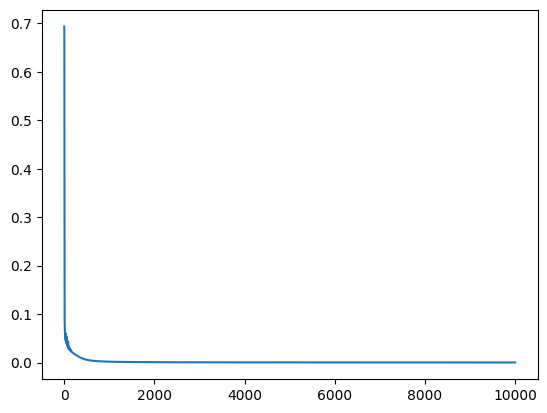

In [215]:
nn_model.fit(X = X_train_scaled, Y = y_train)

# Neural Network Model Performance
At the end I have calculated some useful metrics to evaluate this model.

### Accuracy
Accuracy is calculated by the ratio between correctly assigned labels and total labels. It may not be the best metric in case of unbalanced dataset.

### F1 score
The F1 score is calculated as the harmonic mean of Recall and Precision:
  $$Recall(r) = \frac{TP}{TP + FN} \:\:\:\:\:\:\:\:\:\:\:\:\:\:\: Precision(p) = \frac{TP}{TP + FP}$$
<br>
  $$F1 \: score = \frac{2rp}{r + p}$$

- **High Accuracy**: 96.49%, indicating strong generalization.
- **High F1 Score**: 97.14%, reflecting excellent balance between precision and recall.

The model shows robust performance, making it reliable for accurate predictions on new data.

In [216]:
acc = nn_model.score(X = X_test_scaled, Y = y_test)
f1 = f1_score(y_test, nn_model.predict(X_test_scaled), average='micro')

print(f"Accuracy: {acc * 100:.2f}% ({acc:.4f})")
print(f"F1 Score (micro-average): {f1 * 100:.2f}% ({f1:.4f})")

Accuracy: 96.49% (0.9649)
F1 Score (micro-average): 97.14% (0.9714)
